## Q.1 Does the 'wall_material' of the building cause severity_of_the_damage? 

## Q.2 Does 'per_capita_income' of the area, the building is in, cause the severity_of_the_damage?

In [1]:
# Required libraries
import dowhy
from dowhy import CausalModel
import dowhy.datasets
import pandas as pd
import dowhy.plotter

# Avoiding unnecessary log messges and warnings
import logging
logging.getLogger("dowhy").setLevel(logging.WARNING)
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [2]:
kk = ['hazard', 'median_year_built', 'occupancy', 'walls', 'roofing',\
      'roof_type', 'percent_owner_occupied', 'median_age', 'percent_african_american',\
      'service_ind','income_poverty', 'per_capita_income', 'secondary_hazard_31',\
      'roughness_2', 'target']

df = pd.read_csv('../data/preprocessed.csv')
for i in df.columns:
    if i not in kk:
        df.drop(i, axis =1, inplace = True)


print(df.columns)

Index(['hazard', 'median_year_built', 'occupancy', 'walls', 'roofing',
       'roof_type', 'percent_owner_occupied', 'median_age',
       'percent_african_american', 'service_ind', 'income_poverty',
       'per_capita_income', 'secondary_hazard_31', 'roughness_2', 'target'],
      dtype='object')


In [3]:
data = dowhy.datasets.linear_dataset(
    beta=10,
    num_common_causes=5,
    num_instruments=2,
    num_samples=10000,
    treatment_is_binary=True) 

In [4]:
causal_data = {}
causal_data['first'] = {'data':df, 'treatment':['walls'], 'outcome' : ['target']\
                       , 'common_causes_names' : ['roof_type', 'occupancy','median_age'\
                                                  ,'percent_african_american', 'service_ind', 'income_poverty'\
                                                  , 'per_capita_income', 'secondary_hazard_31', 'roughness_2'\
                                                  , 'hazard', 'roofing']
                       , 'instrument_names' : ['median_year_built', 'percent_owner_occupied']} 
causal_data['second'] = {'data':df, 'treatment':['per_capita_income'], 'outcome' : ['target']\
                       , 'common_causes_names' : ['roof_type', 'occupancy', 'percent_african_american'\
                                                  , 'walls', 'secondary_hazard_31', 'roughness_2'\
                                                  , 'hazard', 'roofing', 'median_year_built', 'percent_owner_occupied']
                       , 'instrument_names' : ['service_ind', 'income_poverty', 'median_age']} 

# MODEL_1

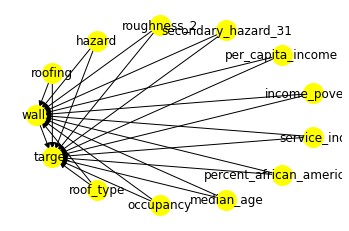

In [5]:
model_1 = CausalModel(data = causal_data['first']["data"], 
                      treatment = causal_data['first']["treatment"][0],
                      outcome = causal_data['first']["outcome"][0],
                      common_causes = causal_data['first']["common_causes_names"],
                      intrumental_variables = causal_data['first']["instrument_names"]) 
model_1.view_model(layout="dot")

### IDENTIFICATION

In [6]:
identified_estimand = model_1.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(target|service_ind,income_poverty,hazard,secondary_hazard
d[walls]                                                                      

                                                                              
_31,median_age,roofing,percent_african_american,roughness_2,roof_type,per_capi
                                                                              

                     
ta_income,occupancy))
                     
Estimand assumption 1, Unconfoundedness: If U→{walls} and U→target then P(target|walls,service_ind,income_poverty,hazard,secondary_hazard_31,median_age,roofing,percent_african_american,roughness_2,roof_type,per_capita_income,occupancy,U) = P(target|walls,service_ind,income_poverty,hazard,secondary_hazard_31,median_age,roofing,percent_african_american,roughness

### ESTIMATION

In [7]:
causal_estimate_reg  = model_1.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression")

print(causal_estimate_reg )
print("Causal Estimate is " + str(causal_estimate_reg.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(target|service_ind,income_poverty,hazard,secondary_hazard
d[walls]                                                                      

                                                                              
_31,median_age,roofing,percent_african_american,roughness_2,roof_type,per_capi
                                                                              

                     
ta_income,occupancy))
                     
Estimand assumption 1, Unconfoundedness: If U→{walls} and U→target then P(target|walls,service_ind,income_poverty,hazard,secondary_hazard_31,median_age,roofing,percent_african_american,roughness_2,roof_type,per_capita_income,occupancy,U) = P(target|walls,service_ind,income_poverty,hazard,secondary_hazard_31,media

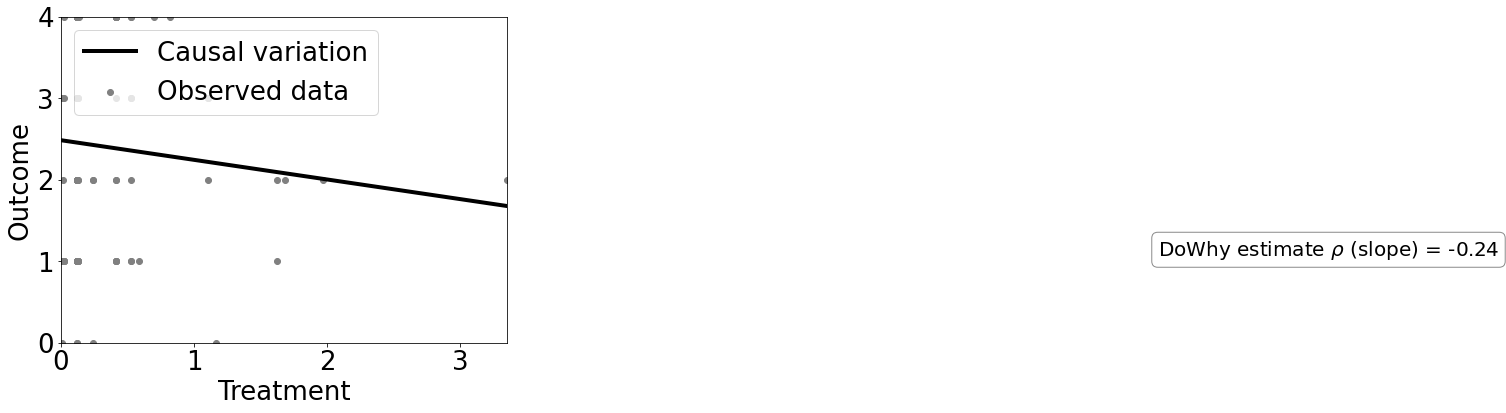

In [12]:
dowhy.plotter.plot_causal_effect(causal_estimate_reg, df['walls'], df['target'])

### REFUTATION  

Add Random Common Cause: Does the estimation method change its estimate after we add an independent random variable as a common cause to the dataset? (Hint: It should not)

In [17]:
res_random = model_1.refute_estimate(identified_estimand, causal_estimate_reg, method_name="random_common_cause")
print(res_random)

Refute: Add a Random Common Cause
Estimated effect:-0.24096272481831615
New effect:-0.2564046267327913



Placebo Treatment: What happens to the estimated causal effect when we replace the true treatment variable with an independent random variable? (Hint: the effect should go to zero)

In [19]:
res_placebo = model_1.refute_estimate(identified_estimand, causal_estimate_reg,
                                    method_name="placebo_treatment_refuter", 
                                    placebo_type="permute",
                                    num_simulations=20)
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:-0.24096272481831615
New effect:-0.013137166538152112
p value:0.4355153345237609

